In [63]:
# import modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns
import dask
import geopandas as gpd
import rasterio.mask
from shapely.geometry import mapping
import rioxarray
from rasterio import features
from affine import Affine
from pyhdf.SD import SD, SDC
from sklearn.metrics import mean_absolute_error,mean_squared_error,precision_score,r2_score,accuracy_score
from datetime import datetime, timedelta

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
# Loading AOD DATASET FILE PATH

aod_file = glob.glob('../DATA/AOD/*')
print(aod_file)
aod_modis_dir = glob.glob(aod_file[-1]+'/*')

aod_modis_dir

['../DATA/AOD\\Aeronet', '../DATA/AOD\\INSAT3D', '../DATA/AOD\\INSAT3DR', '../DATA/AOD\\MODIS']


['../DATA/AOD\\MODIS\\MODIS_2017', '../DATA/AOD\\MODIS\\MODIS_2018']

In [3]:
# MODIS DIR contain sub folder with no time dimension

# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
start_year = np.datetime64('2018')

for path in glob.glob(aod_modis_dir[1]+'/*'):
    
    aod_modis_path.append(glob.glob(path+'/*'))
    day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
    time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[:5],time_stamp[:5]

([['../DATA/AOD\\MODIS\\MODIS_2018\\001\\MOD08_D3.A2018001.061.2018003215357.hdf'],
  ['../DATA/AOD\\MODIS\\MODIS_2018\\002\\MOD08_D3.A2018002.061.2018003215942.hdf'],
  ['../DATA/AOD\\MODIS\\MODIS_2018\\003\\MOD08_D3.A2018003.061.2018004083950.hdf'],
  ['../DATA/AOD\\MODIS\\MODIS_2018\\004\\MOD08_D3.A2018004.061.2018005083354.hdf'],
  ['../DATA/AOD\\MODIS\\MODIS_2018\\005\\MOD08_D3.A2018005.061.2018008181118.hdf']],
 [numpy.datetime64('2018-01-01'),
  numpy.datetime64('2018-01-02'),
  numpy.datetime64('2018-01-03'),
  numpy.datetime64('2018-01-04'),
  numpy.datetime64('2018-01-05')])

In [4]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [5]:
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )
ds_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))

In [19]:
#Loading AOD Dataset for testing 
aod_insat3D = glob.glob(aod_file[1]+'/final_data/2017_18/*')
insat_3D = []
for file in aod_insat3D:
    if file.split('_')[3][5:] == '2018':
        insat_3D.append(file)
        
ds_3D = xr.open_mfdataset(insat_3D).load()


In [20]:
ds_3D

<xarray.Dataset>
Dimensions:    (time: 2107, latitude: 551, longitude: 551)
Coordinates:
  * latitude   (latitude) float64 45.05 44.95 44.85 44.75 ... -9.75 -9.85 -9.95
  * longitude  (longitude) float64 45.05 45.15 45.25 45.35 ... 99.85 99.95 100.0
  * time       (time) datetime64[ns] 2018-01-01T05:30:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... 0.3566 nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [21]:
ds_modis

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * latitude   (latitude) float64 38.5 37.5 36.5 35.5 34.5 ... 11.5 10.5 9.5 8.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
Data variables:
    AOD        (time, latitude, longitude) float64 nan nan nan ... nan nan nan

# slicing,shaping,filtering,regrid

In [22]:
# Slicing
ds_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))
ds_3D = ds_3D.sel(latitude=slice(39,8),longitude=slice(67,98))

In [23]:
# Shaping dataset
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [24]:
sf_dir = '../Data/India_Boundary/India_Boundary.shp'

ds_mask = add_shape_coord_from_data_array(ds_3D, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_3D = ds_mask.drop_vars('MASK')

ds_mask = add_shape_coord_from_data_array(ds_modis, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_modis = ds_mask.drop_vars('MASK')

In [25]:
# Filtering

# 2-sigma rule filter
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 1*std
    return res.where(count>=6)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 1*std
    return res.where(count>=6)

def twoSigfilter(ds):
   
    # Converting hourly to daily timestamp
    daily_timestamp = ds.time.dt.floor('1D')
    unique_day = np.unique(daily_timestamp)
    
    # COUNT PLOT ON TIME DIMENSION
    ds_day_count = ds.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

    # Calculating mean + 2*sigma
    ds_twoSig_pos= ds.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

    # Calculating mean - 2*sigma
    ds_twoSig_neg= ds.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

    # re-arrange coordinates
    ds_twoSig_pos = ds_twoSig_pos[['time','latitude','longitude','AOD']]
    ds_twoSig_neg = ds_twoSig_neg[['time','latitude','longitude','AOD']]

    # Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
    
    print(len(ds_day_count.time.values))
    ds_twoSig_pos.coords['time'] = unique_day
    ds_twoSig_neg.coords['time'] = unique_day
    
    # Flooring hourly time to day time and generate duplicate time index for same hour
    ds.coords['time'] = ds.time.dt.floor('1D')

    # Create a mask for filtering out the data
    mask = (ds['AOD'] < ds_twoSig_pos.sel(time=ds['time'])) & (ds['AOD'] > ds_twoSig_neg.sel(time=ds['time']))

    # Apply the mask to filter out the data
    filtered_data = ds.where(mask)
    
    return filtered_data

In [26]:
ds_3D = twoSigfilter(ds_3D)

365


In [27]:
ds_3D  = ds_3D.resample(time='1D').mean()
ds_modis = ds_modis.resample(time='1D').mean()
ds_3D

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 310, longitude: 310)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [29]:
# regridding 
def regrid_1(ds):
    minx = ds_modis.longitude.min().item()
    maxx = ds_modis.longitude.max().item()
    miny = ds_modis.latitude.min().item()
    maxy = ds_modis.latitude.max().item()


    out_res = 1
    interval_window = out_res/2
    # set up new lat/lon grid
    new_grid_x = np.arange(
        np.ceil(minx / out_res) * out_res,
        (np.floor(maxx / out_res) + 0.5) * out_res,
        out_res
    )
    new_grid_y = np.arange(
        np.ceil(miny / out_res) * out_res,
        (np.floor(maxy / out_res) + 0.5) * out_res,
        out_res
    )
    
    
    return ds.interp(longitude=new_grid_x[:] + interval_window, latitude=new_grid_y[:] + interval_window, method="nearest")

def regrid_2(ds,thres,res):

    out_res = res
    minx = ds_modis.longitude.min().item()
    maxx = ds_modis.longitude.max().item()
    miny = ds_modis.latitude.min().item()
    maxy = ds_modis.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    #print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= thres,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb


In [30]:
ds_merged_coarse_1  = regrid_1(ds_3D)
ds_merged_coarse_1

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 30, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float64 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
  * latitude   (latitude) float64 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [31]:
ds_merged_coarse_2  = regrid_2(ds_3D,0.2,1)
ds_merged_coarse_2

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.5 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

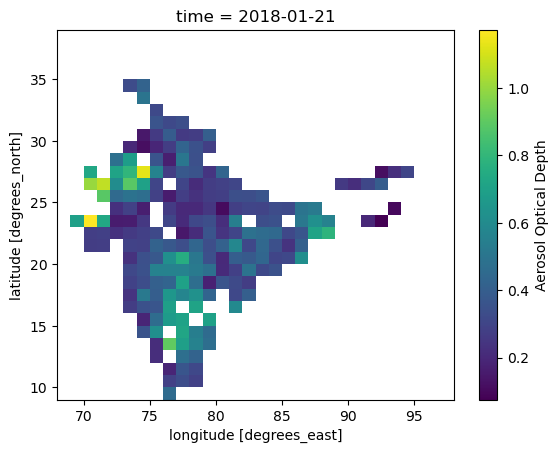

In [32]:
ds_merged_coarse_1.isel(time=20).AOD.plot()

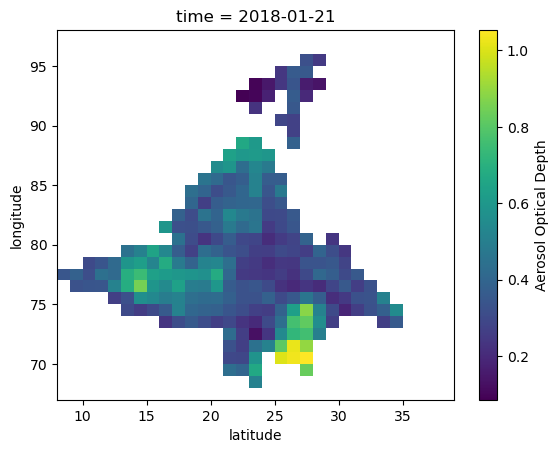

In [34]:
ds_merged_coarse_2.isel(time=20).AOD.plot()

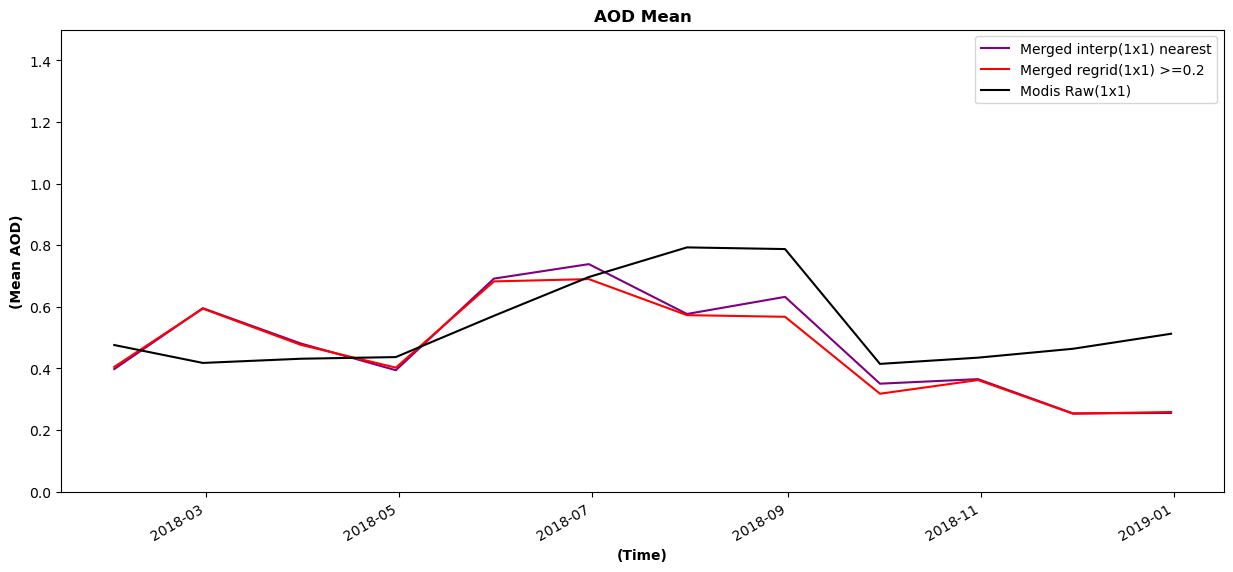

In [48]:
# MONTLY MEAN OVER INDIA
fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_coarse_1['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data2_mean = ds_merged_coarse_2['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data3_mean = ds_modis['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))

colors = ['purple', 'red', 'black']
#colors = colors[:5]

# Set the line colors for each plot using the colors list
for i, (data, label) in enumerate(zip([data1_mean, data2_mean, data3_mean,],
                                      ['Merged interp(1x1) nearest', 'Merged regrid(1x1) >=0.2','Modis Raw(1x1)'])):
    data.plot.line(ax=ax, label=label, color=colors[i])


ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Mean AOD)',weight='bold')
ax.set_title(f'AOD Mean',weight='bold')

ax.set_ylim(0,1.5)
plt.style.use('ggplot')

#plt.savefig('./plots/aod_plot/Insat_vs_Modis/Different_regrid_0.75&0.1_method.png')
plt.show()

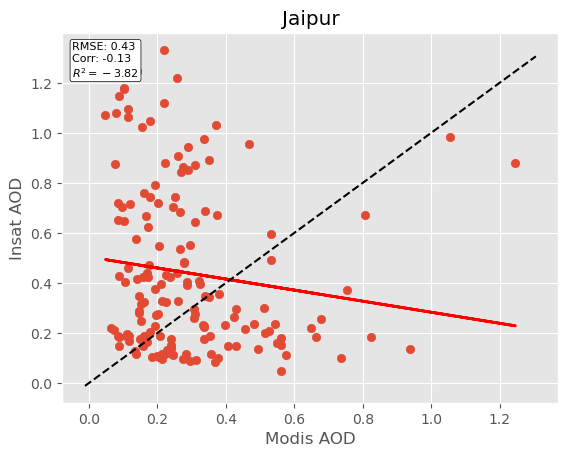

In [83]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

ds_modis_temp = ds_modis.sel(latitude=18.537255,longitude=73.805491,method='nearest')
ds_3D_temp = ds_merged_coarse_2.sel(latitude=26.905817,longitude=75.806217,method='nearest')


#Extract the AOD variable from each dataset
aod1 = ds_modis_temp['AOD'].sortby('time')
aod2 = ds_3D_temp['AOD'].sortby('time')

df = pd.DataFrame({'Modis_AOD': aod1, 'Insat_AOD': aod2})
df = df.dropna(subset=['Modis_AOD','Insat_AOD'])

slope, intercept = np.polyfit(df.Modis_AOD, df.Insat_AOD, 1)
line_of_regression = slope * df.Modis_AOD + intercept

# Create the scatter plot
fig, ax = plt.subplots()
ax.scatter(df.Modis_AOD, df.Insat_AOD)
ax.plot(df.Modis_AOD, line_of_regression, color='r', linewidth=2)

# Add axis labels and a title
ax.set_xlabel('Modis AOD')
ax.set_ylabel('Insat AOD')
ax.set_title('Jaipur')
ax.plot(ax.get_xlim(),ax.get_xlim(), '--', color='black')


# calculate evaluation metrics
mse = mean_squared_error(df.Modis_AOD, df.Insat_AOD)
r_squared = r2_score(df.Modis_AOD, df.Insat_AOD)
rmse = np.sqrt(mse)
corr = np.corrcoef(df.Modis_AOD, df.Insat_AOD)[0, 1]

# add a legend with evaluation metrics
# ax.text(0.01, 0.9, f'Mean Squared Error: {mse:.2f}', transform=ax.transAxes, fontsize=12)
# ax.text(0.01, 0.85, f'R-squared: {r_squared:.2f}', transform=ax.transAxes, fontsize=12)
# ax.text(0.01, 0.8, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=12)
ax.text(0.02, 0.88, f'RMSE: {rmse:.2f}\nCorr: {corr:.2f}\n$R^2 = {r_squared:.2f}$', transform=ax.transAxes, fontsize=8,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
#plt.savefig('../plots/insat_modis_scatter/jaipur_insat_modis.jpg')       
# Display the plot
plt.show()



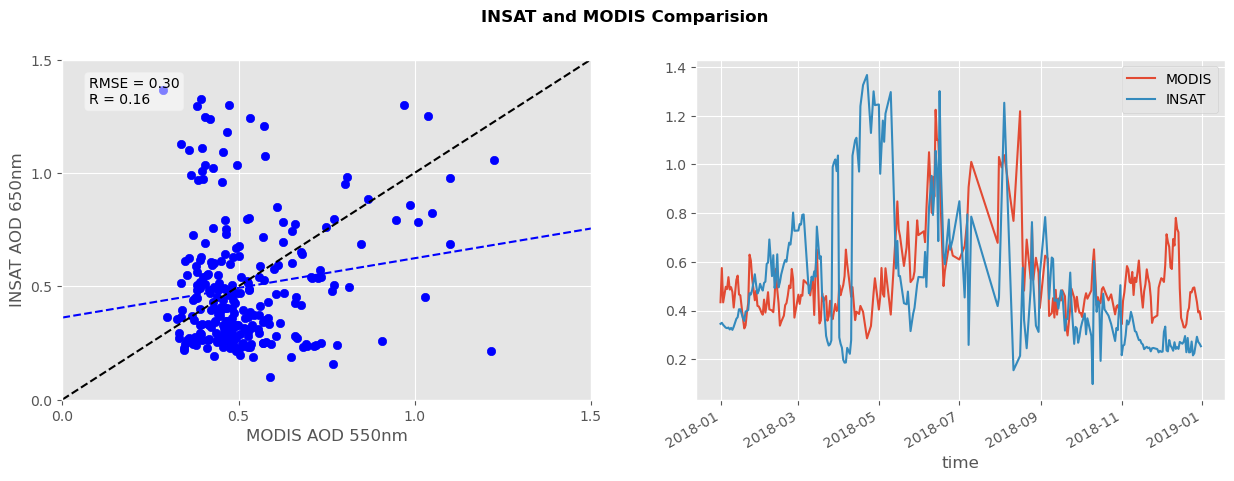

In [59]:
from sklearn.linear_model import LinearRegression

# scatter plot
insat_df = ds_merged_coarse_1.mean(dim=('latitude', 'longitude')).to_dataframe().reset_index()
modis_df = ds_modis.mean(dim=('latitude', 'longitude')).to_dataframe().reset_index()


# Merge the INSAT and MODIS dataframes by time
merged_df = pd.merge(modis_df,insat_df, on='time')
merged_df = merged_df.dropna(subset=['AOD_x', 'AOD_y'], how='any')

merged_df

# Create the scatter plot
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes[0]
ax.scatter(merged_df['AOD_x'], merged_df['AOD_y'], color='blue')
ax.set_xlabel('MODIS AOD 550nm')
ax.set_ylabel('INSAT AOD 650nm')

# Calculate the regression line
regression = LinearRegression().fit(merged_df['AOD_x'].values.reshape(-1, 1), merged_df['AOD_y'].values.reshape(-1, 1))
slope = regression.coef_[0][0]
intercept = regression.intercept_[0]

# Calculate the limits
limit = max(merged_df['AOD_x'].max(), merged_df['AOD_y'].max())

# Add the regression line to the scatter plot
x_vals = np.arange(0,limit+2)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, '--', color='blue')

# RMSE and Corr
rmse = np.sqrt(np.mean((merged_df['AOD_x'] - merged_df['AOD_y']) ** 2))
corr_coef = np.corrcoef(merged_df['AOD_x'], merged_df['AOD_y'])[0,1]

# Add RMSE and correlation coefficient as text inside the plot
textstr = f'RMSE = {rmse:.2f}\nR = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


# Calculate the step
step = 0.5

# Set the limits and step to be the same for both axes
ax.set_xlim([0, limit])
ax.set_ylim([0, limit])
ax.set_xticks(np.arange(0, limit+step, step))
ax.set_yticks(np.arange(0, limit+step, step))
ax.plot(ax.get_xlim(),ax.get_xlim(), '--', color='black')

ax = axes[1]
merged_df.plot(x='time', y=['AOD_x', 'AOD_y'],label=['MODIS','INSAT'], ax=ax)

#plt.savefig('../plots/aod_plot/scatter_plot/insat_interp_vs_modis_2018.jpg')
# Display the plot

plt.suptitle('INSAT and MODIS Comparision',weight='bold')
plt.show()

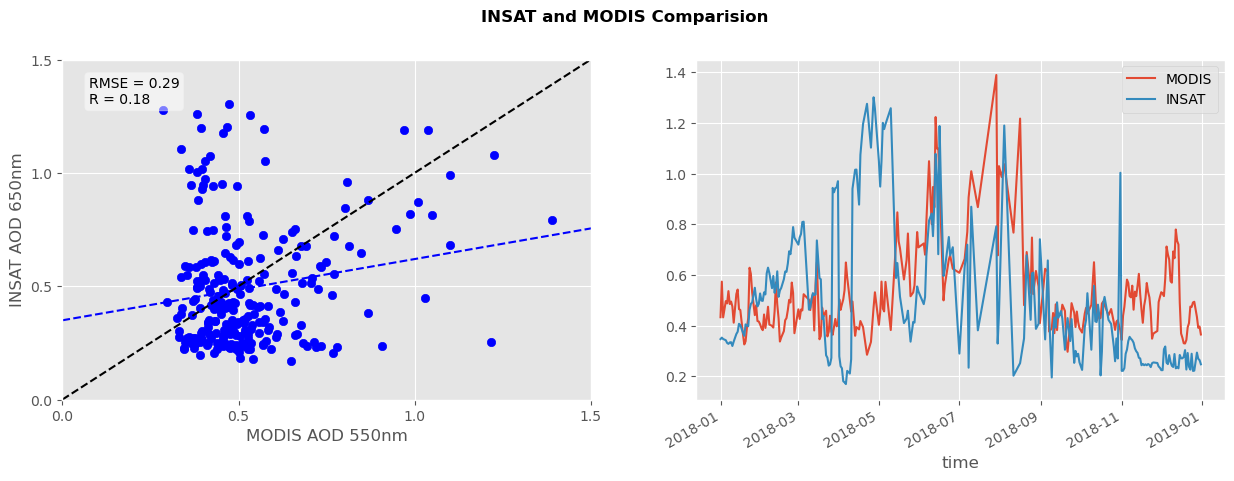

In [62]:
from sklearn.linear_model import LinearRegression

# scatter plot
insat_df = ds_merged_coarse_2.mean(dim=('latitude', 'longitude')).to_dataframe().reset_index()
modis_df = ds_modis.mean(dim=('latitude', 'longitude')).to_dataframe().reset_index()


# Merge the INSAT and MODIS dataframes by time
merged_df = pd.merge(modis_df,insat_df, on='time')
merged_df = merged_df.dropna(subset=['AOD_x', 'AOD_y'], how='any')

merged_df

# Create the scatter plot
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes[0]
ax.scatter(merged_df['AOD_x'], merged_df['AOD_y'], color='blue')
ax.set_xlabel('MODIS AOD 550nm')
ax.set_ylabel('INSAT AOD 650nm')

# Calculate the regression line
regression = LinearRegression().fit(merged_df['AOD_x'].values.reshape(-1, 1), merged_df['AOD_y'].values.reshape(-1, 1))
slope = regression.coef_[0][0]
intercept = regression.intercept_[0]

# Calculate the limits
limit = max(merged_df['AOD_x'].max(), merged_df['AOD_y'].max())

# Add the regression line to the scatter plot
x_vals = np.arange(0,limit+2)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, '--', color='blue')

# RMSE and Corr
rmse = np.sqrt(np.mean((merged_df['AOD_x'] - merged_df['AOD_y']) ** 2))
corr_coef = np.corrcoef(merged_df['AOD_x'], merged_df['AOD_y'])[0,1]

# Add RMSE and correlation coefficient as text inside the plot
textstr = f'RMSE = {rmse:.2f}\nR = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


# Calculate the step
step = 0.5

# Set the limits and step to be the same for both axes
ax.set_xlim([0, limit])
ax.set_ylim([0, limit])
ax.set_xticks(np.arange(0, limit+step, step))
ax.set_yticks(np.arange(0, limit+step, step))
ax.plot(ax.get_xlim(),ax.get_xlim(), '--', color='black')

ax = axes[1]
merged_df.plot(x='time', y=['AOD_x', 'AOD_y'],label=['MODIS','INSAT'], ax=ax)

#plt.savefig('../plots/aod_plot/scatter_plot/insat_regrid_vs_modis_2018.jpg')
# Display the plot

plt.suptitle('INSAT and MODIS Comparision',weight='bold')
plt.show()